<a href="https://colab.research.google.com/github/chengg21/APS360/blob/main/Handwriting_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
import os, zipfile, tarfile
import pathlib
import json
import re
import gzip
import shutil
import concurrent.futures
from tqdm import tqdm
import torch, torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.models import Wide_ResNet50_2_Weights
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import time
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extracting files


In [4]:
smhd_path = '/content/drive/MyDrive/Datasets/RMIT/SMHD-lines.zip'
extract_smhd = "/content/drive/MyDrive/Datasets/RMIT/Raw"

iam_path = "/content/drive/MyDrive/Datasets/IAM_Handwritten/lines.zip"

extract_path = "/content/datasets"

In [5]:
# #SMHD Dataset
with zipfile.ZipFile(smhd_path) as zf:
        zf.extractall(extract_path+"/SMHD")

#IAM Dataset
with zipfile.ZipFile(iam_path) as zf:
        zf.extractall(extract_path)

In [6]:
smhd_labels_path = "/content/datasets/SMHD/SMHD.txt"
smhd_save_path = "/content/datasets/SMHD"

punct_fix = re.compile(r'\s+([,.;:!?])') # Spaces following punctuation

smhd_labels = []
smhd_img_ids = []

with open(smhd_labels_path) as f:
    for raw in f:
        raw = raw.rstrip('\n')
        smhd_img_id, rest = raw.split(',', 1)
        writer_num = int(smhd_img_id.split('-')[0])
        if writer_num > 490:
            continue

        rest = rest.lstrip()
        parts = rest.split(' ', 1)

        if len(parts) == 2:
            _, smhd_label = parts
        else:
            smhd_label = rest

        smhd_label = punct_fix.sub(r'\1', smhd_label) # Remove any spaces following punctuation

        smhd_img_ids.append(smhd_img_id)
        smhd_labels.append(smhd_label)

print(smhd_labels[:5])
print(smhd_img_ids[:5])

# Note: Can probably cut this later on
img_paths = [
    os.path.join(smhd_save_path, smhd_img_id.split('-')[0], f'{smhd_img_id}.png')
    for smhd_img_id in smhd_img_ids
]

print(img_paths[:5])

['Bombay Phenotype:-', 'That type of Phenotypic character of Blood group', 'in which can individual is Phenotypically " O "', 'and genotyphically is type A or type B Blood', 'group. # called Bombay Phenotype. #']
['0001-000', '0001-001', '0001-002', '0001-003', '0001-004']
['/content/datasets/SMHD/0001/0001-000.png', '/content/datasets/SMHD/0001/0001-001.png', '/content/datasets/SMHD/0001/0001-002.png', '/content/datasets/SMHD/0001/0001-003.png', '/content/datasets/SMHD/0001/0001-004.png']


In [7]:
# Loads EMNIST dataset
emnist_dataset = torchvision.datasets.EMNIST(root='.',
                                     split="byclass",
                                     download=True)

emnist_save_path = "/content/datasets/EMNIST"

# Limiter to balance how many each character is produced
emnist_count = {char: 0 for char in emnist_dataset.classes}

filled = False

for idx, (img, label) in enumerate(emnist_dataset):
    # Note: label is the indice of classes
    char = emnist_dataset.classes[label] # Gets the character of the image

    os.makedirs(f"{emnist_save_path}/{char}", exist_ok=True)
    # Creates a directory with the character

    # Adds the image to the dataset
    if (emnist_count[char] < 1000):
      img.save(f"{emnist_save_path}/{char}/{idx}.png")
      emnist_count[char] += 1
      if ((emnist_count[x] for x in emnist_dataset.classes) == 1000):
        filled = True
    if filled:
      break



100%|██████████| 562M/562M [00:04<00:00, 117MB/s]


In [8]:
emnist_labels = [char for char in emnist_dataset.classes for x in range(1000) ]
print(emnist_labels)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

# Reading labels and file paths

In [9]:
iam_truth_save_path = "/content/datasets/lines/lines.txt"
iam_save_path = "/content/datasets/lines"

with open(iam_truth_save_path, "r") as f:
  lines = f.readlines()
  iam_paths = [line.split()[0] for line in lines if not line.startswith('#')]
  iam_labels = [line.split()[-1].replace("|"," ") for line in lines if not line.startswith('#')]

print(iam_paths[:5])
print(iam_labels[:5])

['a01-000u-00', 'a01-000u-01', 'a01-000u-02', 'a01-000u-03', 'a01-000u-04']
['A MOVE to stop Mr. Gaitskell from', 'nominating any more Labour life Peers', 'is to be made at a meeting of Labour', 'Ps tomorrow . Mr. Michael Foot has', 'put down a resolution on the subject']


In [10]:
class Handwriting_Images(ImageFolder):
    def __init__(self, root, labels, replacement_tensors=None, *args, **kwargs):
        super().__init__(root, *args, **kwargs)
        self.basic_latin = [chr(c) for c in range(ord(' '), ord('~')+1)]
        self.char_to_idx = {char: idx+1 for idx, char in enumerate(self.basic_latin)}
        # 0 reserved for blank token in CTC
        self.labels = labels
        self.replacement_tensors = replacement_tensors
        if replacement_tensors is not None:
            assert len(replacement_tensors) == len(self.samples), "Replacement tensors length mismatch"

    def __getitem__(self, index):
        # Use replacement tensor if provided, else load from path
        if self.replacement_tensors is not None:
            sample = self.replacement_tensors[index]
        else:
            path, _ = self.samples[index]
            sample = self.loader(path)  # original image loading

        label = self.labels[index]
        target_length = len(label)
        target = np.array(self.encode_text(label, self.char_to_idx), dtype=np.int32)

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label, target_length, target

    def encode_text(self, text, char_to_idx):
        return [char_to_idx[char] for char in text]

In [11]:
from torch.nn.utils.rnn import pad_sequence

def my_collate_fn(batch):
    images, labels, target_lengths, targets = zip(*batch)
    # convert images to batch tensor (all same shape, so stack is fine)
    images = torch.stack(images)
    # keep lists of targets (no stack)

    # Convert each target (sequence) to a tensor
    targets = [torch.tensor(t, dtype=torch.long) for t in targets]

    # Pad the variable-length targets to the max length in the batch
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return images, labels, target_lengths, targets

In [12]:
def get_model_name(model, lr, bs, decay, num_epochs, debug):
  path = "{0}_hidden{1}_layers{2}_lr{3}_bs{4}_decay{5}_epoch{6}".format(model.name, model.hidden_size, model.num_layers, lr, bs, decay, num_epochs)
  if (debug):
    path += "_debug"
  return path

def plot_curve(path):
  train_loss = np.loadtxt(f"{path}_train_loss.csv")
  train_char_err = np.loadtxt(f"{path}_train_char_err.csv")
  train_word_err = np.loadtxt(f"{path}_train_word_err.csv")
  val_loss = np.loadtxt(f"{path}_val_loss.csv")
  val_char_err = np.loadtxt(f"{path}_val_char_err.csv")
  val_word_err = np.loadtxt(f"{path}_val_word_err.csv")

  num_epoch = len(train_loss)

  plt.title("Train vs Validation Loss")
  plt.plot(range(1, num_epoch+1), train_loss, label="Train")
  plt.plot(range(1, num_epoch+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="best")
  plt.show()

  plt.title("Train vs Validation Character Error")
  plt.plot(range(1, num_epoch+1), train_char_err, label="Train")
  plt.plot(range(1, num_epoch+1), val_char_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Character Error")
  plt.legend(loc="best")
  plt.show()

  plt.title("Train vs Validation Word Error")
  plt.plot(range(1, num_epoch+1), train_word_err, label="Train")
  plt.plot(range(1, num_epoch+1), val_word_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Word Error")
  plt.legend(loc="best")
  plt.show()

In [13]:
from PIL import Image
#rescales tensor img to 224 x 9408
class RescaleTransform:
  def __init__(self):
    self.fixed_height = 56
    self.fixed_width = 2352

  def __call__(self,img):
    old_width, old_height = img.size
    new_width = int(old_width * (self.fixed_height / old_height))
    rescale_transform = transforms.Compose(
        [transforms.Resize((self.fixed_height, new_width)),
        transforms.Pad((0, 0, self.fixed_width - new_width, 0)),
        ])
    return rescale_transform(img)

In [14]:
def get_data_loader(bs, debug = False):

  normal_transform = transforms.Compose(
      [RescaleTransform(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # Initializes all datasets
  iam_dataset = Handwriting_Images(root=iam_save_path, labels=iam_labels, transform=normal_transform)
  smhd_dataset = Handwriting_Images(root=smhd_save_path, labels=smhd_labels, transform=normal_transform)
  #emist_dataset = Handwriting_Images(root=emnist_save_path, labels=emnist_labels, transform=normal_transform)

  # Combines them in a list
  combined_dataset = []
  combined_dataset.append(iam_dataset)
  combined_dataset.append(smhd_dataset)
  #combined_dataset.append(emist_dataset)

  # Merges list as one dataset
  total_dataset = torch.utils.data.ConcatDataset(combined_dataset)

  # Marks all indices
  indices = []
  if debug:
    for i in range(bs):
      indices.append(i)
  else:
    for i in range(len(total_dataset)):
      indices.append(i)

  # Shuffles indices
  np.random.shuffle(indices)

  # Split indices (train:val:test = 80:10:10)
  train_val_split = int(len(indices) * 0.8) #split at 80%
  val_test_split = train_val_split + int(len(indices) * 0.1) #split at 90%

  # Split into training and validation indices
  train_indices, val_indices, test_indices = indices[:train_val_split], indices[train_val_split:val_test_split], indices[val_test_split:]

  # Create sampler objects
  train_sampler = SubsetRandomSampler(train_indices)
  train_loader = torch.utils.data.DataLoader(total_dataset, batch_size=bs, collate_fn=my_collate_fn,
                                               num_workers=1, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(val_indices)
  val_loader = torch.utils.data.DataLoader(total_dataset, batch_size=bs, collate_fn=my_collate_fn,
                                              num_workers=1, sampler=val_sampler)

  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(total_dataset, batch_size=bs, collate_fn=my_collate_fn,
                                             num_workers=1, sampler=test_sampler)

  return train_loader, val_loader, test_loader




# Transform for normalization

In [15]:
# Normal transform for validation and testing data
normal_transform = transforms.Compose(
      [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load ASL training data
standard_dataset = Handwriting_Images(root=iam_save_path, labels=iam_labels, transform=normal_transform)
standard_loader = torch.utils.data.DataLoader(standard_dataset, batch_size=1)

In [16]:
emnist_dataset = Handwriting_Images(root=emnist_save_path, labels=iam_labels, transform=normal_transform)
emnist_loader = torch.utils.data.DataLoader(emnist_dataset, batch_size=1)

In [17]:
print(len(emnist_dataset))

62000


In [18]:
# print(standard_loader.dataset.classes)

torch.Size([3, 89, 1661])
('A MOVE to stop Mr. Gaitskell from',)
33
tensor([34,  1, 46, 48, 55, 38,  1, 85, 80,  1, 84, 85, 80, 81,  1, 46, 83, 15,
         1, 40, 66, 74, 85, 84, 76, 70, 77, 77,  1, 71, 83, 80, 78],
       dtype=torch.int32)


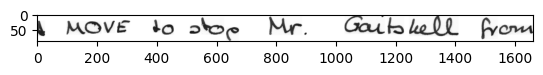

In [19]:
data_iter = iter(standard_loader)

image, label, target_length, target = next(data_iter)

single_image = image[0]
single_label = label
single_char_count = target_length[0]
single_encoded_char = target.squeeze()

# torch.Size([3, 89, 1661])
# ('A MOVE to stop Mr. Gaitskell from',)
# 33
# tensor([34,  1, 46, 48, 55, 38,  1, 85, 80,  1, 84, 85, 80, 81,  1, 46, 83, 15,
#         1, 40, 66, 74, 85, 84, 76, 70, 77, 77,  1, 71, 83, 80, 78])

print(single_image.shape)
print(single_label)
print(single_char_count.numpy())
print(single_encoded_char)

img = np.transpose(single_image, [1,2,0])
img = np.clip(img / 2 + 0.5, 0, 1)
plt.imshow(img)

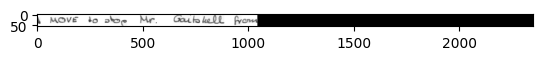

In [20]:
rescaler = RescaleTransform()
img = transforms.functional.to_pil_image(single_image)
img = rescaler(img)
# img = np.transpose(img, [1,2,0])
# img = np.clip(img / 2 + 0.5, 0, 1)
plt.imshow(img)

# Hidden Markov Model

In [ ]:
import numpy as np
from collections import defaultdict
import os
from PIL import Image
from skimage.feature import hog

class HiddenMarkovModel:
    def __init__(self, states, observations):
        self.states = states
        self.observations = observations
        self.start_prob = {state: 1.0 / len(states) for state in states}
        self.trans_prob = {s: {s_: 1.0 / len(states) for s_ in states} for s in states}
        self.emit_prob = {s: {o: 1.0 / len(observations) for o in observations} for s in states}

    def viterbi(self, observed_seq):
        T = len(observed_seq)
        dp = [{} for _ in range(T)]
        path = {}

        # Initialize base cases (t == 0)
        for s in self.states:
            dp[0][s] = self.start_prob[s] * self.emit_prob[s].get(observed_seq[0], 1e-6)
            path[s] = [s]

        # Run Viterbi for t > 0
        for t in range(1, T):
            new_path = {}
            for curr_state in self.states:
                (prob, prev_state) = max(
                    (dp[t-1][s] * self.trans_prob[s][curr_state] * self.emit_prob[curr_state].get(observed_seq[t], 1e-6), s)
                    for s in self.states
                )
                dp[t][curr_state] = prob
                new_path[curr_state] = path[prev_state] + [curr_state]
            path = new_path

        # Final best path
        n = max(self.states, key=lambda s: dp[T-1][s])
        return path[n], dp[T-1][n]

    def train_supervised(self, labeled_sequences):
        state_counts = defaultdict(int)
        trans_counts = defaultdict(lambda: defaultdict(int))
        emit_counts = defaultdict(lambda: defaultdict(int))

        for state_seq, obs_seq in labeled_sequences:
            prev_state = None
            for state, obs in zip(state_seq, obs_seq):
                state_counts[state] += 1
                emit_counts[state][obs] += 1
                if prev_state is not None:
                    trans_counts[prev_state][state] += 1
                prev_state = state

        self.states = list(state_counts.keys())

        # Normalize safely (with division-by-zero checks)
        self.start_prob = {s: 1.0 / len(self.states) for s in self.states}
        self.trans_prob = {
            s: {s2: (trans_counts[s][s2] / sum(trans_counts[s].values())
                    if sum(trans_counts[s].values()) > 0 else 0.0)
                for s2 in self.states}
            for s in self.states
        }
        self.emit_prob = {
            s: {o: emit_counts[s][o] / state_counts[s] for o in emit_counts[s]}
            for s in self.states
        }


    def run_on_single_sample(self, image_folder, iam_paths, iam_labels, index=0):
      """Runs HMM training on a single image/label pair using HOG features and visualizes gradient features."""
      import glob
      import matplotlib.pyplot as plt

      # Step 1: Get the label and filename
      img_id = iam_paths[index]
      label = iam_labels[index]
      label_seq = list(label.upper())

      # Step 2: Use glob to search for correct image path in subfolders
      matches = glob.glob(os.path.join(image_folder, "*", img_id))
      if not matches:
          raise FileNotFoundError(f"Image not found: {img_id} in {image_folder}")
      img_path = matches[0]

      # Step 3: Load and preprocess image
      image = Image.open(img_path).convert('L').resize((128, 32))
      image_np = np.array(image)

      # Step 4: Extract HOG features + visualize
      features, hog_image = hog(image_np,
                                pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2),
                                visualize=True,
                                feature_vector=True)
      obs_seq = list(np.round(features * 10).astype(int))

      # HOG Visualization (gradient strength)
      plt.figure(figsize=(10, 4))
      plt.imshow(hog_image, cmap='gray')
      plt.title("HOG Visualization (Gradient Strengths)")
      plt.axis('off')
      plt.show()

      # Histogram of HOG feature values (gradient magnitude)
      plt.figure(figsize=(8, 4))
      plt.hist(features, bins=30, color='purple', edgecolor='black')
      plt.title("Histogram of HOG Feature Values")
      plt.xlabel("Gradient Magnitude (per bin)")
      plt.ylabel("Frequency")
      plt.grid(True)
      plt.show()

      # Step 5: Reset HMM with correct state and observation space
      self.states = sorted(set(label_seq))
      self.observations = sorted(set(obs_seq))
      self.__init__(self.states, self.observations)

      # Step 6: Train
      self.train_supervised([(label_seq[:len(obs_seq)], obs_seq)])

      print("HMM trained on one sample:")
      print("Label:", ''.join(label_seq))
      print("Obs sequence length:", len(obs_seq))
      return label_seq, obs_seq


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import io
from PIL import Image
import numpy as np

class HiddenMarkovModel(HiddenMarkovModel):  # Extend the existing class

      def plot_transition_histogram(self):
        """Plots a histogram of all non-zero transition probabilities."""
        probs = []
        for s_from in self.states:
            for s_to in self.states:
                prob = self.trans_prob.get(s_from, {}).get(s_to, 0)
                if prob > 0:
                    probs.append(prob)

        plt.figure(figsize=(8, 5))
        plt.hist(probs, bins=10, color='teal', edgecolor='black')
        plt.title("Histogram of Transition Probabilities")
        plt.xlabel("Transition Probability")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()



In [ ]:
import os

# List the first 10 files in your image folder
print(os.listdir("/content/datasets/lines")[:10])


['g07', 'f07', 'e06', 'm01', 'l07', 'h05', 'b04', 'd06', 'b02', 'e04']


In [ ]:
import os

# Manually print a few example paths
for subdir in os.listdir(iam_save_path):
    sub_path = os.path.join(iam_save_path, subdir)
    if os.path.isdir(sub_path):
        for file in os.listdir(sub_path):
            print(os.path.join(sub_path, file))
        break  # Just print from one folder


/content/datasets/lines/g07/g07-030
/content/datasets/lines/g07/g07-022b
/content/datasets/lines/g07/g07-007a
/content/datasets/lines/g07/g07-028a
/content/datasets/lines/g07/g07-000b
/content/datasets/lines/g07/g07-042
/content/datasets/lines/g07/g07-077a
/content/datasets/lines/g07/g07-065
/content/datasets/lines/g07/g07-026a
/content/datasets/lines/g07/g07-050
/content/datasets/lines/g07/g07-084
/content/datasets/lines/g07/g07-003b
/content/datasets/lines/g07/g07-026b
/content/datasets/lines/g07/g07-014
/content/datasets/lines/g07/g07-069a
/content/datasets/lines/g07/g07-047
/content/datasets/lines/g07/g07-003a
/content/datasets/lines/g07/g07-000a
/content/datasets/lines/g07/g07-007b
/content/datasets/lines/g07/g07-079a
/content/datasets/lines/g07/g07-071a
/content/datasets/lines/g07/g07-014b
/content/datasets/lines/g07/g07-010b
/content/datasets/lines/g07/g07-038
/content/datasets/lines/g07/g07-018a
/content/datasets/lines/g07/g07-022a
/content/datasets/lines/g07/g07-028b
/content/

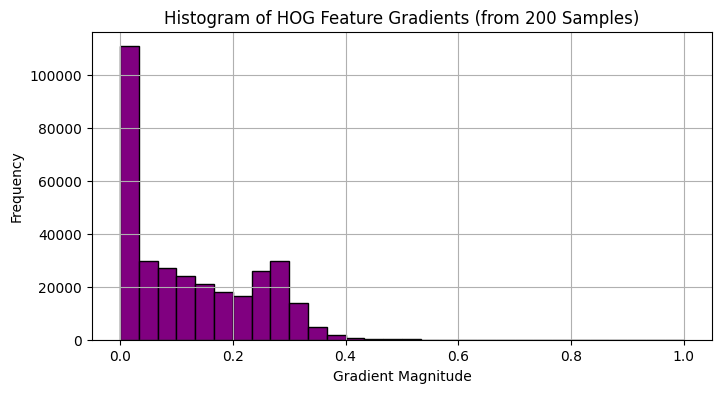

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image
import numpy as np
import os

# Build mapping from img_id to label using iam_paths
imgid_to_label = {pid: label for pid, label in zip(iam_paths, iam_labels)}

# Find valid samples from disk that are also in iam_paths
valid_samples = []
for root, dirs, files in os.walk(iam_save_path):
    for file in files:
        if file.endswith(".png"):
            img_id = file.replace(".png", "")
            if img_id in imgid_to_label:
                valid_samples.append((img_id, os.path.join(root, file)))
    if len(valid_samples) >= 200:
        break

# Extract sequences and accumulate all HOG features
hog_features_all = []
labeled_sequences = []
for img_id, img_path in valid_samples:
    label_seq = list(imgid_to_label[img_id].upper())
    image = Image.open(img_path).convert('L').resize((128, 32))
    image_np = np.array(image)
    features, _ = hog(image_np, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, feature_vector=True)
    obs_seq = list(np.round(features * 10).astype(int))
    labeled_sequences.append((label_seq[:len(obs_seq)], obs_seq))
    hog_features_all.extend(features)

# Plot histogram of HOG gradients
if hog_features_all:
    plt.figure(figsize=(8, 4))
    plt.hist(hog_features_all, bins=30, color='purple', edgecolor='black')
    plt.title("Histogram of HOG Feature Gradients (from 200 Samples)")
    plt.xlabel("Gradient Magnitude")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("No valid HOG features found to plot.")


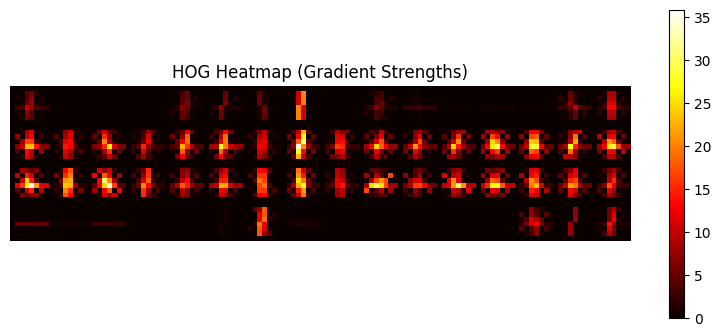

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color
from PIL import Image
import numpy as np

# Load and preprocess image
image = Image.open(img_path).convert('L').resize((128, 32))
image_np = np.array(image)

# Extract HOG features and visualization
features, hog_image = hog(image_np,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualize=True,
                          feature_vector=True)

# Display HOG as heatmap
plt.figure(figsize=(10, 4))
plt.imshow(hog_image, cmap='hot')  # Try 'plasma', 'inferno', etc.
plt.title("HOG Heatmap (Gradient Strengths)")
plt.axis('off')
plt.colorbar()
plt.show()


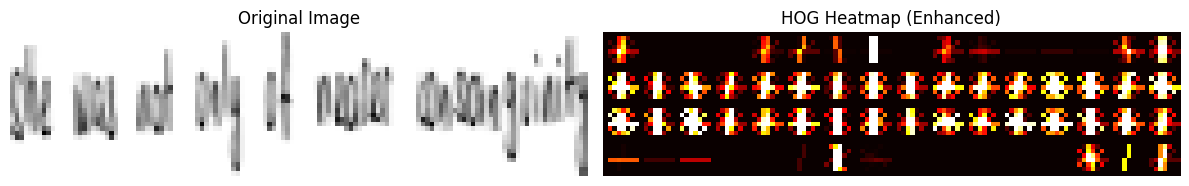

In [ ]:
from skimage import exposure
import matplotlib.pyplot as plt

# Rescale the hog image for better contrast
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot original and HOG side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(image_np, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(hog_image_rescaled, cmap='hot')
ax2.set_title('HOG Heatmap (Enhanced)')
ax2.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Predict using Viterbi on the first sample
true_states, obs_seq = labeled_sequences[0]
predicted_states, _ = hmm.viterbi(obs_seq)

# Display comparison
print("True Label:     ", ''.join(true_states))
print("Predicted Label:", ''.join(predicted_states))

# Accuracy calculation
def sequence_accuracy(true_seq, pred_seq):
    matches = sum(t == p for t, p in zip(true_seq, pred_seq))
    total = len(true_seq)
    return matches / total if total > 0 else 0

acc = sequence_accuracy(true_states, predicted_states)
print(f"Prediction Accuracy: {acc:.2%}")


True Label:      HIS ALMOST FILIAL LOVE FOR HER , HER ALMOST
Predicted Label: HATUY BUT BUY ... HEREXCOR HER , BUY BUY .... ...... SHEE , BUTHE , NG , .... , ......... HALD BUT HAL HE .......... HE ..... HERERERNGHER BUY ... ..... # BUY ..... BUTHEXCOVEXCOVER BUY ..... # ... , HEXCOVEXCOVERND ... # BUY .......... HINOVEXCOVE , , ....... HE ..... HER , , SHER .... HE ..... HE ..... HETUYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY

# Proposed Model

Evaluation Function

In [21]:
import torch
import torch.nn.functional as F

def levenshtein(a, b):
    # Returns edit-distance between two strings
    if a == b:
        return 0
    if len(a) == 0:
        return len(b)
    if len(b) == 0:
        return len(a)

    if len(a) > len(b):
        a, b = b, a

    prev_row = range(len(a) + 1)
    for i, cb in enumerate(b, start=1):
        cur_row = [i]
        for j, ca in enumerate(a, start=1):
            insert_cost = cur_row[j-1] + 1
            delete_cost = prev_row[j] + 1
            replace_cost = prev_row[j-1] + (ca != cb)
            cur_row.append(min(insert_cost, delete_cost, replace_cost))
        prev_row = cur_row
    return prev_row[-1]

def evaluate(model, loader, criterion, decoder):
    model.eval()
    total_loss = 0.0
    total_char_errs = 0.0
    total_word_errs = 0.0
    total_items  = 0
    total_chars = 0
    total_words = 0
    with torch.no_grad():
        for imgs, labels, target_lengths, targets in loader:
            # sample, label, target_length, target
            imgs = imgs.to(device)
            target_lengths = torch.tensor(target_lengths, dtype=torch.long)
            targets = torch.tensor(targets, dtype=torch.long)
            batch_size = imgs.size(0)

            ################## Model output
            output = model(imgs)
            log_probs = F.log_softmax(output, dim=2)
            input_lengths = torch.full(size=(batch_size,), fill_value=output.size(0),
                                           dtype=torch.long).to(device)

            loss = criterion(log_probs, targets, input_lengths, target_lengths)
            total_loss += loss.item() * batch_size
            total_items += batch_size

            pred_sentences = decoder.decode(log_probs, input_lengths)

            for pred, truth in zip(pred_sentences, labels):
                # Character level
                total_char_errs += levenshtein(pred, truth)
                total_chars += len(truth)

                # Word level
                pred_words = pred.split()
                truth_words = truth.split()
                total_word_errs += levenshtein(pred_words, truth_words)
                total_words += len(truth_words)

    avg_loss = total_loss / total_items
    cer = total_char_errs / max(1, total_chars)
    wer = total_word_errs / max(1, total_words)
    return avg_loss, cer, wer

In [22]:
class Decoder():
  def __init__(self):
    self.basic_latin = [chr(c) for c in range(ord(' '), ord('~')+1)]
    self.idx_to_char = {idx+1: char for idx, char in enumerate(self.basic_latin)}
    self.blank_idx = 0

  def decode(self, log_probs, input_lengths):
    _, bs, _ = log_probs.shape # bs = batch size
    char_probs = log_probs.argmax(dim=2)
    # takes maximum from (timesteps, classes) -> (char index, batch)

    outputs = []
    for n in range(bs):
      encoded_sentence = char_probs[:input_lengths[n],n].tolist()
      decoded_sentence = []
      prev = self.blank_idx
      for encoded_char in encoded_sentence:
        if encoded_char != prev and encoded_char != self.blank_idx:
          decoded_sentence.append(self.idx_to_char[encoded_char])
        prev = encoded_char
      outputs.append("".join(decoded_sentence))

    return outputs


In [30]:
#ls = learning rate, bs = batch size
def train(model, train_loader, val_loader, lr=1e-2, bs=64, decay=1e-8, num_epochs=30, debug = False, use_cuda = False):
  criterion = nn.CTCLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

  #Insert data loader
  # train_loader, val_loader, test_loader = get_data_loader(bs=bs, debug=debug)
  # loss and error tracking
  train_word_err = np.zeros(num_epochs)
  train_char_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_word_err = np.zeros(num_epochs)
  val_char_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)
  decoder = Decoder()

  #Creating folder
  folder_name = get_model_name(model, lr, bs, decay, num_epochs, debug)
  save_dir = "/content/models/"+folder_name
  os.makedirs(save_dir, exist_ok=True)

  #Train
  model.train()

  test = True

  start_time = time.time()
  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_char_errs = 0.0
    total_train_word_errs = 0.0
    total_chars = 0
    total_words = 0
    total_items = 0
    for idx, data in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
      # return sample, label, target_length, target
      imgs, labels, target_lengths, targets = data
      imgs = imgs.to(device)
      target_lengths = torch.tensor(target_lengths, dtype=torch.long)
      targets = torch.tensor(targets, dtype=torch.long)
      bs = imgs.size(0) #just in case for last batch size

      optimizer.zero_grad()
      output = model(imgs)
      input_lengths = torch.full(size=(bs,), fill_value=output.size(0),
                                 dtype=torch.long).to(device)

      loss = criterion(output, targets, input_lengths, target_lengths)
      loss.backward()
      optimizer.step()

      # Loss, CER, and WER calculations
      log_probs = F.log_softmax(output, dim=2)
      total_items += bs
      total_train_loss += loss.item() * bs
      pred_sentences = decoder.decode(log_probs, input_lengths)

      for pred, truth in zip(pred_sentences, labels):
            # Character level
            total_train_char_errs += levenshtein(pred, truth)
            total_chars += len(truth)

            # Word level
            pred_words = pred.split()
            truth_words = truth.split()
            if test or (epoch+1 == num_epochs):
              print(pred_words)
              print(truth_words)
              test = False
            total_train_word_errs += levenshtein(pred_words, truth_words)
            total_words += len(truth_words)

      del imgs, output, log_probs, loss
      torch.cuda.empty_cache()

    # Saving loss, CER, and WER
    train_loss[epoch] = float(total_train_loss)/total_items
    train_char_err[epoch] = float(total_train_char_errs)/ max(1, total_chars)
    train_word_err[epoch] = float(total_train_word_errs)/ max(1, total_words)
    val_loss[epoch], val_char_err[epoch], val_word_err[epoch] = evaluate(model, val_loader, criterion, decoder)

    # Saving model (set to 10 times)
    if (epoch % (num_epochs/10) == 0) or (epoch == num_epochs - 1):
      model_name = f"{model.name}_epoch_{epoch}.pth"
      torch.save(model.state_dict(), save_dir+"/"+model_name)
  end_time = time.time()
  total_time = end_time - start_time
  print(f"Time taken: {total_time}")

  # Saving plotting values
  np.savetxt(f"{save_dir}/{model_name}_train_loss.csv", train_loss)
  np.savetxt(f"{save_dir}/{model_name}_train_char_err.csv", train_char_err)
  np.savetxt(f"{save_dir}/{model_name}_train_word_err.csv", train_word_err)
  np.savetxt(f"{save_dir}/{model_name}_val_loss.csv", val_loss)
  np.savetxt(f"{save_dir}/{model_name}_val_char_err.csv", val_char_err)
  np.savetxt(f"{save_dir}/{model_name}_val_word_err.csv", val_word_err)

Model definition

In [48]:
NUM_CLASSES = ord("~") - ord(" ") + 2

class CRNN_WRN(nn.Module):
    def __init__(self, feature_h=56, feature_c=3, hidden_size=256, num_layers=2):
        super().__init__()
        self.name = "test"
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6, 12, 3),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(12, 24, 3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.rnn_in = 24 * 5

        self.rnn = nn.LSTM(
            input_size=self.rnn_in,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size * 2, NUM_CLASSES)

    def forward(self, features):
        x=self.cnn(features)
        B, C, H, W = x.shape  # (B, 3, 56, 2352)
        x = x.view(B, W, C*H)
        rnn_out, _ = self.rnn(x)         # (B, 74, 2*hidden_size)
        logits = self.fc(rnn_out)        # (B, 74, NUM_CLASSES)
        return logits.permute(1, 0, 2)   # (74, B, NUM_CLASSES)

# class CRNN_WRN(nn.Module):
#     """
#     CRNN with a Wide-ResNet-50-2 backbone.
#     Image height must be 32 px; width can vary.
#     """
#     def __init__(self, img_h: int = 256, hidden_size: int = 256, num_layers: int = 2,
#                  pretrained: bool = True, freeze_cnn: bool = False):
#         super().__init__()
#         self.name = "CRNN_WideResNet50_2"
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         #Load Wide-ResNet-50-2
#         wrn = models.wide_resnet50_2(pretrained=pretrained)

#         #Make first conv accept 1-channel input
#         old = wrn.conv1
#         new = nn.Conv2d(3, old.out_channels, kernel_size=old.kernel_size,
#                         stride=old.stride, padding=old.padding, bias=False)
#         if pretrained:
#             with torch.no_grad():
#                 new.weight[:] = old.weight.mean(dim=1, keepdim=True)     #average RGB values to gray
#         wrn.conv1 = new

#         #Strip off global-avg-pool & FC head  → stride-32 feature map
#         self.cnn = nn.Sequential(*list(wrn.children())[:-2])  # output: (B, 2048, 1, W′)

#         if freeze_cnn:
#             for p in self.cnn.parameters():
#                 p.requires_grad = False

#         #RNN & classifier
#         self.map_h  = img_h // 32          # = 1 when img_h==32
#         self.rnn_in = 2048 * self.map_h    # 2048 × 1
#         self.rnn = nn.LSTM(
#             input_size    = self.rnn_in,
#             hidden_size   = self.hidden_size,
#             num_layers    = self.num_layers,
#             bidirectional = True,
#             batch_first   = True
#         )
#         self.fc  = nn.Linear(hidden_size * 2, NUM_CLASSES)

#     def forward(self, x):
#         """
#         x : (B, 1, 32, W)   →   logits : (T=W′, B, NUM_CLASSES)
#         """
#         f = self.cnn(x)                    # (B, 2048, 1, W′)
#         B, C, H, W = f.shape               # H = 1
#         f = f.permute(0, 3, 1, 2).contiguous().view(B, W, C * H)   # (B, W′, 2048)
#         rnn_out, _ = self.rnn(f)           # (B, W′, 2*hidden)
#         logits = self.fc(rnn_out)          # (B, W′, classes)
#         return logits.permute(1, 0, 2)     # (T, B, classes) for CTC


In [25]:
class FeaturesWithStringsDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets, target_lengths, strings):
        self.features = features
        self.targets = targets
        self.target_lengths = target_lengths
        self.strings = strings  # Keep original strings!

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.target_lengths[idx], self.strings[idx]

In [26]:
import torch, torch.nn as nn, torchvision
from torchvision.models import Wide_ResNet50_2_Weights
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

# ── pretrained Wide-ResNet-50-2 trunk (no avg-pool, no FC) ─────────────────────
wrn = torchvision.models.wide_resnet50_2(
    weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1
).eval().to(device)

feature_extractor = nn.Sequential(*list(wrn.children())[:-2]).eval().to(device)
for p in feature_extractor.parameters():
    p.requires_grad = False

# ── cache CNN features for an entire loader ───────────────────────────────────
def save_features(loader):
    feats = []
    with torch.no_grad():
        for imgs, *_ in loader:            # works with your my_collate_fn
            imgs = imgs.to(device)                # (B, C, 32, W)
            if imgs.shape[1] == 1:                # replicate if grayscale
                imgs = imgs.repeat(1, 3, 1, 1)
            f = feature_extractor(imgs)           # (B, 2048, 1, W′)
            f = f.flatten(2).permute(0, 2, 1).cpu()  # (B, W′, 2048)
            feats.append(f)

            del imgs, f
            torch.cuda.empty_cache()
    return torch.cat(feats)
# output.shape = (B, 2048, 2, 74)

# ── extract & wrap in TensorDatasets ──────────────────────────────────────────
train_loader, val_loader, test_loader = get_data_loader(bs=10, debug=True)

train_feats = save_features(train_loader)
val_feats = save_features(val_loader)
test_feats = save_features(test_loader)

for img, *_ in train_loader:
  img = train_feats

for img, *_ in val_loader:
  img = train_feats

for img, *_ in test_loader:
  img = test_feats


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 156MB/s]


# Training

In [27]:
train_loader, val_loader, test_loader = get_data_loader(bs=10, debug=True)

In [49]:
net = CRNN_WRN().to(device)
train(net, train_loader, val_loader)

Training Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipython-input-30-3747965342.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.long)
Training Epoch 1: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

['ZXZBbzZXG7Z']
['nominating', 'any', 'more', 'Labour', 'life', 'Peers']



Training Epoch 30: 100%|██████████| 1/1 [00:09<00:00,  9.75s/it]

[]
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from']
[]
['nominating', 'any', 'more', 'Labour', 'life', 'Peers']
[]
['put', 'down', 'a', 'resolution', 'on', 'the', 'subject']
[]
['and', 'he', 'is', 'to', 'be', 'backed', 'by', 'Mr.', 'Will']
[]
['any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a']
[]
['is', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour']
[]
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'nominating']
[]
['Ps', 'tomorrow', '.', 'Mr.', 'Michael', 'Foot', 'has']


Time taken: 245.36886048316956


In [32]:
cd /content/models/test_hidden256_layers2_lr0.01_bs64_decay1e-08_epoch30

/content/models/test_hidden256_layers2_lr0.01_bs64_decay1e-08_epoch30


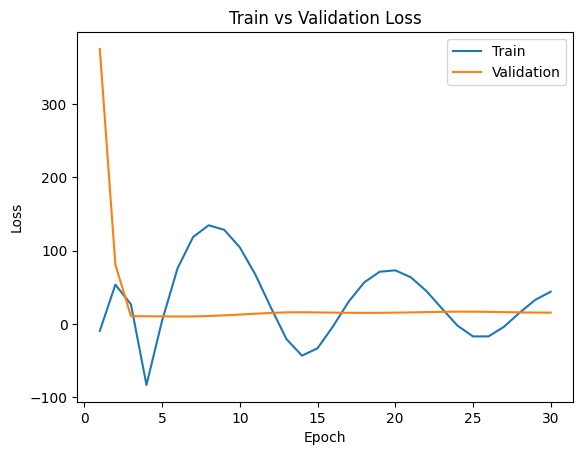

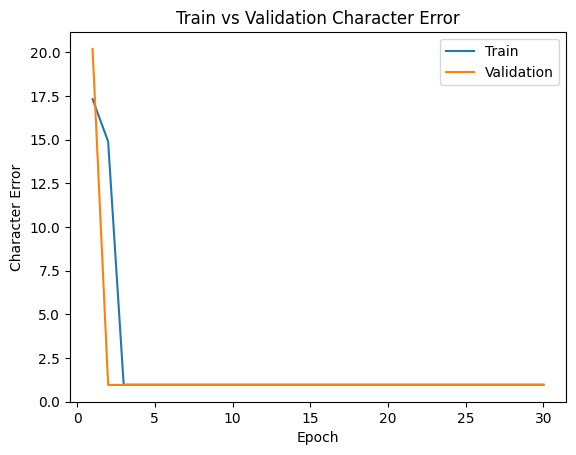

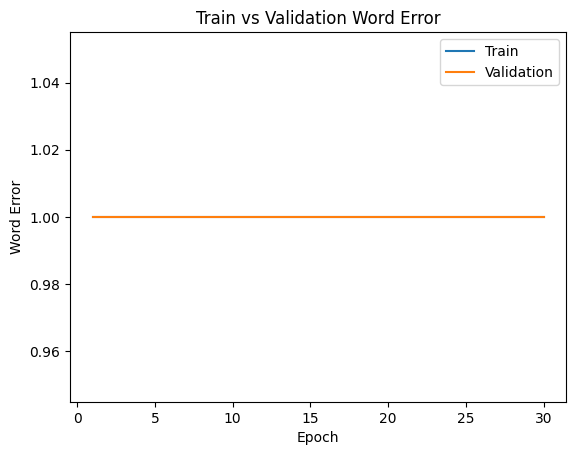

In [35]:
plot_curve("test_epoch_29")